<a href="https://colab.research.google.com/github/dibab64/deeplearning-dibab/blob/main/Fingerprint_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, \
                                    Concatenate, GlobalMaxPooling2D, \
                                    MaxPooling2D, GlobalAveragePooling2D, \
                                    AveragePooling2D

In [ ]:
pip install opendatasets

#Import datasets from kaggle.com

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/ruizgara/socofing/data")
#629d247b92b8bdd63d8ea85cfe54fecd

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: furkansoyupak
Your Kaggle Key: ··········


100%|██████████| 838M/838M [00:06<00:00, 141MB/s]


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
os.listdir()
path = "/content/socofing/SOCOFing/"
m_path = "/content/soco/Male"
f_path = "/content/soco/Female"
os.makedirs("/content/soco/Male")
os.makedirs("/content/soco/Female")

In [ ]:
import cv2
imags = 'content/soco/Grayscale/Female/103__F_Left_little_finger.BMP'
image = cv2.imread(imags, cv2.IMREAD_UNCHANGED)
print('image dtype ', image.dtype)
imags.dtype()

AttributeError: ignored

In [ ]:
easy = "/content/socofing/SOCOFing/Altered/Altered-Easy"
medium = "/content/socofing/SOCOFing/Altered/Altered-Easy"
hard = "/content/socofing/SOCOFing/Altered/Altered-Easy"
real = "/content/socofing/SOCOFing/Real"

In [ ]:
def move(where):
    for file in os.listdir(where):
        # If the file name contains "__M_", copy the file to the `m_path` directory.
        if "__M_" in file:
            shutil.move(os.path.join(where, file), os.path.join(m_path, file))

        # If the file name contains "__F_", copy the file to the `f_path` directory.
        if "__F_" in file:
            shutil.move(os.path.join(where, file), os.path.join(f_path, file))

In [ ]:
move(real)

In [ ]:
ds = "/content/soco/Grayscale"

In [ ]:
from PIL import Image

def convert_rgb_to_grayscale(input_folder, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        # Open the image
        with Image.open(input_path) as img:
            # Convert to grayscale
            grayscale_img = img.convert('L')

            # Save the grayscale image
            grayscale_img.save(output_path)

In [ ]:
input_folder = '/content/soco/Male'
output_folder = '/content/soco/Grayscale/Male/'

convert_rgb_to_grayscale(input_folder, output_folder)

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 0

#Load, Split and scale data


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(ds,
                                                   shuffle = True,
                                                   image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = BATCH_SIZE,
                                                   #color_mode = 'grayscale',
                                                   labels='inferred',
                                                   #color_mode = 'grayscale',
                                                   #labels = 'inferred'
                                                   )


Found 6000 files belonging to 2 classes.


In [ ]:
class_names = data.class_names
class_names

['Female', 'Male']

In [ ]:
for image_batch, labels_batch in data.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())


(32, 128, 128, 3)
[1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1]


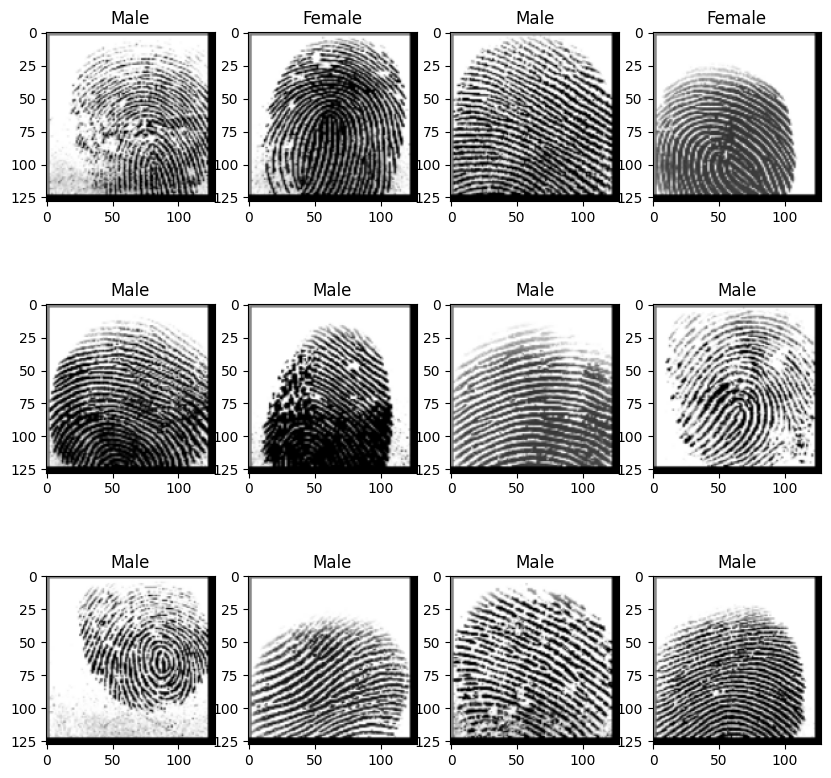

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, class_batch in data.take(3):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[i]])

In [ ]:
def get_split_dataset(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
  assert (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_split_dataset(data)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_scale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
augmentaion = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (augmentaion(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

 # CNN model


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_class = 2

model = models.Sequential([
    resize_and_scale,
    augmentaion,
    layers.Conv2D(128, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_class, activation='softmax'),
])

model.build(input_shape=input_shape)

ValueError: ignored

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, None)    0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, None)    0         
                                                                 
 conv2d_15 (Conv2D)          (32, 126, 126, 128)       3584      
                                                                 
 batch_normalization_15 (Ba  (32, 126, 126, 128)       512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (32, 63, 63, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (32, 63, 63, 128)        

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, batch_size = BATCH_SIZE, callbacks=reduce_lr, verbose=1)

Epoch 1/10
150/150 [==============================] - 28s 94ms/step - loss: 0.6709 - accuracy: 0.7889 - val_loss: 0.5092 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - 13s 87ms/step - loss: 0.4961 - accuracy: 0.7968 - val_loss: 0.5465 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 3/10
150/150 [==============================] - 13s 87ms/step - loss: 0.4878 - accuracy: 0.7968 - val_loss: 0.4980 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 4/10
150/150 [==============================] - 13s 87ms/step - loss: 0.4813 - accuracy: 0.7958 - val_loss: 0.5279 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 5/10
150/150 [==============================] - 13s 87ms/step - loss: 0.4769 - accuracy: 0.7968 - val_loss: 0.5804 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 6/10
150/150 [==============================] - 13s 86ms/step - loss: 0.4753 - accuracy: 0.7958 - val_loss: 0.7770 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 7/10
150/150 [==============================] - 13s 

KeyboardInterrupt: ignored

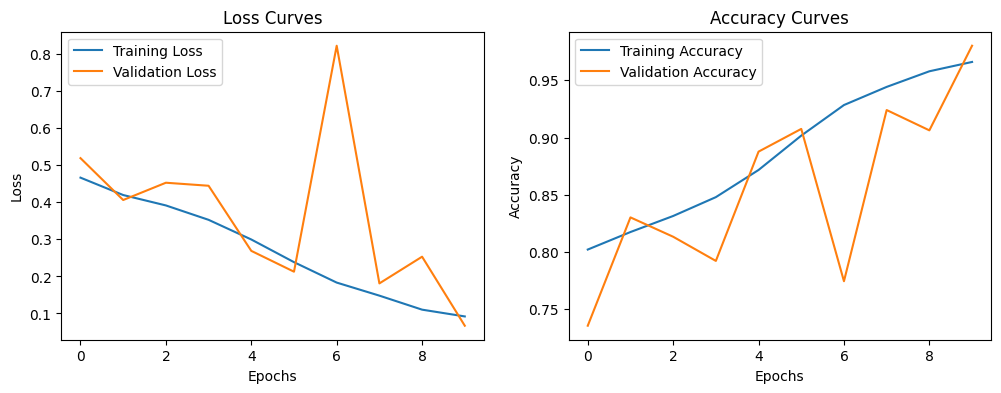

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

In [ ]:
model.evaulate(test)

AttributeError: ignored

In [ ]:
#pip install split-folders

In [ ]:
path = "/content/socofing/SOCOFing/Real"
print(os.listdir(path))

['Female', 'Male']


In [ ]:
import splitfolders
splitfolders.ratio(path,seed=1337, output="Fingerprints-Splitted", ratio=(0.6, 0.2, 0.2))

Copying files: 6000 files [00:01, 3685.12 files/s]


In [ ]:
data_iterator

In [ ]:
train_dir = "/content/Fingerprints-Splitted/train/"
valid_dir = "/content/Fingerprints-Splitted/val"
test_dir = "/content/Fingerprints-Splitted/test"

In [ ]:
image_size = (256, 256)
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels = "inferred",
    label_mode = "int",
    class_names = ["Female", "Male"],
    shuffle = True,
    image_size = image_size,
    batch_size = batch_size,
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory = valid_dir,
    labels = "inferred",
    label_mode = "int",
    class_names = ["Female", "Male"],
    image_size = image_size,
    batch_size = batch_size,
    shuffle = False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels = "inferred",
    label_mode = "int",
    class_names = ["Female", "Male"],
    image_size = image_size,
    batch_size = batch_size,
    shuffle = False
)

classes = train_ds.class_names


Found 3600 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.


In [ ]:
scaler = tf.keras.layers.Rescaling(1./255) # Defining scaler values between 0 to 1
# Rescaling datasets
train_ds = train_ds.map(lambda x, y: (scaler(x), y))
test_ds = test_ds.map(lambda x, y: (scaler(x), y))
valid_ds = valid_ds.map(lambda x, y: (scaler(x), y))


In [ ]:
len(valid_ds)

10

In [ ]:
print('\nTraining Dataset:', train_ds)
print('\nTesting Dataset:', test_ds)
print('\nValidation Dataset:', valid_ds)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [ ]:
img, labels = [], []
for label, feature in train_dir:
    labels.append(label)
    img.append(feature)
train_ds = np.array(img).reshape(-1, img_size, img_size, 1)
train_ds = train_ds / 255.0
from keras.utils.np_utils import to_categorical
train_labels = to_categorical(labels, num_classes = 2)


ValueError: ignored

In [ ]:
def visualize_dataset(dataset: tf.data.Dataset):
    plt.figure(figsize=(24,18))
    for images, labels in dataset.take(1):
        for i in range(64):
            plt.subplot(8, 8, i+1)
            plt.imshow(images[i])
            plt.title(classes[labels[i].numpy()])
            plt.axis('off')

In [ ]:
visualize_dataset(train_ds)

In [ ]:
import random
random.shuffle(train_dir)
#random.shuffle(test_ds)

TypeError: ignored

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = tf.keras.Sequential([
                  tf.keras.layers.InputLayer((256, 256, 3)),
                  tf.keras.layers.Rescaling(1/255.0),
                  Conv2D(28, (3, 3), strides=(1, 1), padding="same"),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.Activation('relu'),
                  Conv2D(28, (3, 3), strides=(1, 1), padding="valid"),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.Activation('relu'),
                  MaxPooling2D(pool_size=(2, 2)),
                  tf.keras.layers.Dropout(rate=0.25),
                  Flatten(),
                  Dense(100),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.Activation('relu'),
                  tf.keras.layers.Dropout(rate=0.5),
                  Dense(10, activation='softmax')
                    ])

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_71 (Conv2D)          (None, 256, 256, 28)      784       
                                                                 
 batch_normalization_11 (Ba  (None, 256, 256, 28)      112       
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 256, 256, 28)      0         
                                                                 
 conv2d_72 (Conv2D)          (None, 254, 254, 28)      7084      
                                                                 
 batch_normalization_12 (Ba  (None, 254, 254, 28)      112       
 tchNormalization)                                   

In [ ]:
model.compile(optimizer = optimizers.Adam(1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model.fit(train_ds,
          validation_data = valid_ds,
          epochs=30,
          validation_split=0.2,
          callbacks=[early_stopping_cb],
          verbose=1)

Epoch 1/30
29/29 [==============================] - 67s 859ms/step - loss: 2.6212 - accuracy: 0.2633 - val_loss: 1.2312 - val_accuracy: 0.6825
Epoch 2/30
29/29 [==============================] - 22s 743ms/step - loss: 1.1171 - accuracy: 0.6592 - val_loss: 1.1269 - val_accuracy: 0.5675
Epoch 3/30
29/29 [==============================] - 23s 759ms/step - loss: 0.6451 - accuracy: 0.7953 - val_loss: 0.8721 - val_accuracy: 0.6533
Epoch 4/30
29/29 [==============================] - 23s 778ms/step - loss: 0.4171 - accuracy: 0.8667 - val_loss: 0.6081 - val_accuracy: 0.7950
Epoch 5/30
29/29 [==============================] - 23s 772ms/step - loss: 0.2748 - accuracy: 0.9189 - val_loss: 0.5451 - val_accuracy: 0.7950
Epoch 6/30
29/29 [==============================] - 23s 755ms/step - loss: 0.1831 - accuracy: 0.9556 - val_loss: 0.5831 - val_accuracy: 0.7950
Epoch 7/30
29/29 [==============================] - 24s 793ms/step - loss: 0.1567 - accuracy: 0.9622 - val_loss: 0.7021 - val_accuracy: 0.7950

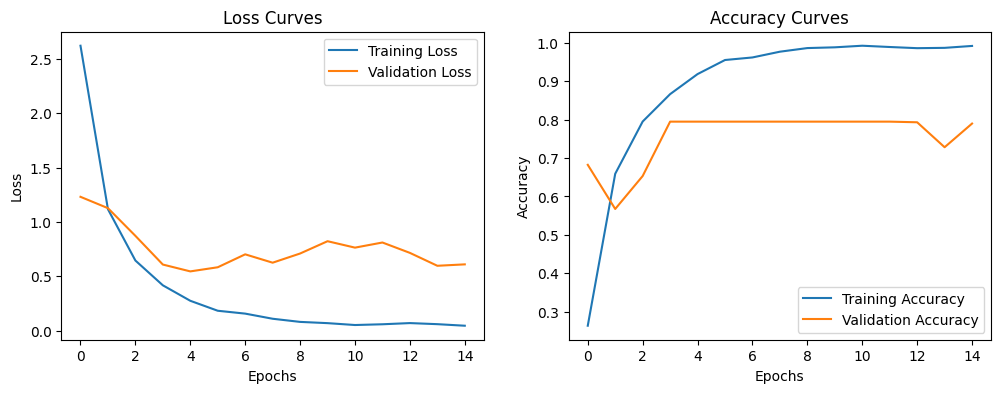

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()